In [1]:
import os,csv,re
import pandas as pd
import numpy as np
import scanpy as sc
import math
import SpaGCN as spg
from scipy.sparse import issparse
import random, torch
import warnings
warnings.filterwarnings("ignore")
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import SpaGCN as spg
#In order to read in image data, we need to install some package. Here we recommend package "opencv"
#inatll opencv in python
#!pip3 install opencv-python
import cv2
from pathlib import Path
from scanpy import read_10x_h5
import anndata
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, \
                            homogeneity_completeness_v_measure
from sklearn.metrics.cluster import contingency_matrix
from sklearn.preprocessing import LabelEncoder
import numpy as np
import scanpy 

In [5]:
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    cm = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

In [6]:
def calculate_clustering_matrix(pred, gt, sample, methods_):
    df = pd.DataFrame(columns=['Sample', 'Score', 'PCA_or_UMAP', 'Method', "test"])
    
    pca_ari = adjusted_rand_score(pred, gt)
    df = df.append(pd.Series([sample, pca_ari, "pca", methods_, "Adjusted_Rand_Score"],
                             index=['Sample', 'Score', 'PCA_or_UMAP', 'Method', "test"]), ignore_index=True)
   
    pca_nmi = normalized_mutual_info_score(pred, gt)
    df = df.append(pd.Series([sample, pca_nmi, "pca", methods_, "Normalized_Mutual_Info_Score"],
                             index=['Sample', 'Score', 'PCA_or_UMAP', 'Method', "test"]), ignore_index=True)
    
    pca_purity = purity_score(pred, gt)
    df = df.append(pd.Series([sample, pca_purity, "pca", methods_, "Purity_Score"],
                             index=['Sample', 'Score', 'PCA_or_UMAP', 'Method', "test"]), ignore_index=True)
    
    pca_homogeneity, pca_completeness, pca_v_measure = homogeneity_completeness_v_measure(pred, gt)
    
    df = df.append(pd.Series([sample, pca_homogeneity, "pca", methods_, "Homogeneity_Score"],
                             index=['Sample', 'Score', 'PCA_or_UMAP', 'Method', "test"]), ignore_index=True)

    
    df = df.append(pd.Series([sample, pca_completeness, "pca", methods_, "Completeness_Score"],
                             index=['Sample', 'Score', 'PCA_or_UMAP', 'Method', "test"]), ignore_index=True)
 
    df = df.append(pd.Series([sample, pca_v_measure, "pca", methods_, "V_Measure_Score"],
                             index=['Sample', 'Score', 'PCA_or_UMAP', 'Method', "test"]), ignore_index=True)
    return df

In [2]:
BASE_PATH = Path("/scratch/90days/uqxtan9/Human_Brain_spatialLIBD")
MARKER_GENE_PATH = BASE_PATH / "marker_gene.tsv"

In [3]:
# here we include all 12 samples
sample_list = ["151507", "151508", "151509",
               "151510", "151669", "151670",
               "151671", "151672", "151673",
               "151674", "151675", "151676"]

In [7]:
for i in range(12):
    sample = sample_list[i]
    adata = read_10x_h5(BASE_PATH / sample / "filtered_feature_bc_matrix.h5")
    spatial=pd.read_csv(BASE_PATH / sample / "spatial/tissue_positions_list.csv",sep=",",header=None,na_filter=False,index_col=0) 
    adata.obs["x1"]=spatial[1]
    adata.obs["x2"]=spatial[2]
    adata.obs["x3"]=spatial[3]
    adata.obs["x4"]=spatial[4]
    adata.obs["x5"]=spatial[5]
    #Select captured samples
    adata=adata[adata.obs["x1"]==1]
    adata.var_names=[i.upper() for i in list(adata.var_names)]
    adata.var["genename"]=adata.var.index.astype("str")
    adata.write_h5ad(BASE_PATH / sample / "{}_spaGCN.h5ad".format(sample))

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'genename' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'genename' as categorical
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  29.477233022425033 134.30750047472108 40.144995243818755
Var of x,y,z =  6252621.155503006 5320894.161992535 6252621.155503008
Run 1: l [0.01, 1000], p [0.0, 148.15217311031813]
Run 2: l [0.01, 500.005], p [0.0, 25.904523849487305]
Run 3: l [0.01, 250.0075], p [0.0, 3.798725128173828]
Run 4: l [125.00874999999999, 250.0075], p [0.4550950527191162, 3.798725128173828]
Run 5: l [125.00874999999999, 187.508125], p [0.4550950527191162, 1.628591537475586]
Run 6: l [125.00874999999999, 156.2584375], p [0.4550950527191162, 0.9323179721832275]
Run 7: l [125.00874999999999, 140.63359375], p [0.4550950527191162, 0.6683287620544434]
Run 8: l [125.00874999999999, 132.821171875], p [0.4550950527191162, 0.5556210279464722]
recommended l =  128.91496093749998
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  6
Initializing cluster centers with 

... storing 'ground_truth' as categorical


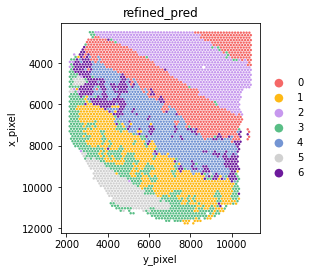

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  28.547864966477558 161.25266113623735 38.69745856824778
Var of x,y,z =  6612301.522024141 5377052.118163594 6612301.522024141
Run 1: l [0.01, 1000], p [0.0, 148.54784340436805]
Run 2: l [0.01, 500.005], p [0.0, 26.335655212402344]
Run 3: l [0.01, 250.0075], p [0.0, 3.9278626441955566]
Run 4: l [125.00874999999999, 250.0075], p [0.48416221141815186, 3.9278626441955566]
Run 5: l [125.00874999999999, 187.508125], p [0.48416221141815186, 1.699552059173584]
Run 6: l [125.00874999999999, 156.2584375], p [0.48416221141815186, 0.9797717332839966]
Run 7: l [125.00874999999999, 140.63359375], p [0.48416221141815186, 0.7059574127197266]
Run 8: l [125.00874999999999, 132.821171875], p [0.48416221141815186, 0.588821530342102]
Run 9: l [125.00874999999999, 128.91496093749998], p [0.48416221141815186, 0.534966230392456]
recommended l =  126.96185546874999
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, reso

... storing 'ground_truth' as categorical


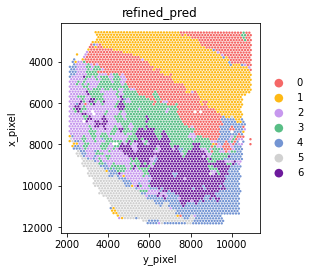

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  29.977798765542325 159.88090184119477 35.64700845898526
Var of x,y,z =  6954766.123245565 6219639.75248683 6954766.123245566
Run 1: l [0.01, 1000], p [0.0, 139.15116286355857]
Run 2: l [0.01, 500.005], p [0.0, 25.000930786132812]
Run 3: l [0.01, 250.0075], p [0.0, 3.764033794403076]
Run 4: l [125.00874999999999, 250.0075], p [0.45681464672088623, 3.764033794403076]
Run 5: l [125.00874999999999, 187.508125], p [0.45681464672088623, 1.6277472972869873]
Run 6: l [125.00874999999999, 156.2584375], p [0.45681464672088623, 0.9344061613082886]
Run 7: l [125.00874999999999, 140.63359375], p [0.45681464672088623, 0.6703994274139404]
Run 8: l [125.00874999999999, 132.821171875], p [0.45681464672088623, 0.5575382709503174]
recommended l =  128.91496093749998
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  6
Initializing cluster centers w

... storing 'ground_truth' as categorical


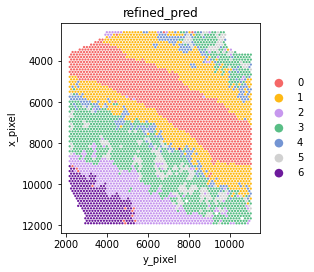

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  28.804515351217297 107.56090873815958 38.764078604329455
Var of x,y,z =  6511733.839876174 6135285.956270563 6511733.839876172
Run 1: l [0.01, 1000], p [0.0, 130.43966860379768]
Run 2: l [0.01, 500.005], p [0.0, 22.44185447692871]
Run 3: l [0.01, 250.0075], p [0.0, 3.2562942504882812]
Run 4: l [125.00874999999999, 250.0075], p [0.38834357261657715, 3.2562942504882812]
Run 5: l [125.00874999999999, 187.508125], p [0.38834357261657715, 1.3921034336090088]
Run 6: l [125.00874999999999, 156.2584375], p [0.38834357261657715, 0.7957479953765869]
Run 7: l [125.00874999999999, 140.63359375], p [0.38834357261657715, 0.5702072381973267]
Run 8: l [132.821171875, 140.63359375], p [0.47404539585113525, 0.5702072381973267]
Run 9: l [132.821171875, 136.7273828125], p [0.47404539585113525, 0.5207899808883667]
recommended l =  134.77427734375
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
E

... storing 'ground_truth' as categorical


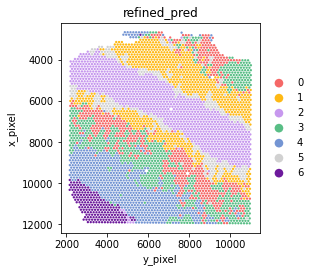

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  21.47139925878313 94.53883189309703 38.675975773569135
Var of x,y,z =  4878342.999073859 5112584.1516970815 5112584.151697081
Run 1: l [0.01, 1000], p [0.0, 137.28137635688373]
Run 2: l [0.01, 500.005], p [0.0, 22.106647491455078]
Run 3: l [0.01, 250.0075], p [0.0, 3.0998315811157227]
Run 4: l [125.00874999999999, 250.0075], p [0.36925506591796875, 3.0998315811157227]
Run 5: l [125.00874999999999, 187.508125], p [0.36925506591796875, 1.322035789489746]
Run 6: l [125.00874999999999, 156.2584375], p [0.36925506591796875, 0.7562664747238159]
Run 7: l [125.00874999999999, 140.63359375], p [0.36925506591796875, 0.5421581268310547]
Run 8: l [132.821171875, 140.63359375], p [0.450772762298584, 0.5421581268310547]
recommended l =  136.7273828125
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  7
Initializing cluster centers with louvai

... storing 'ground_truth' as categorical


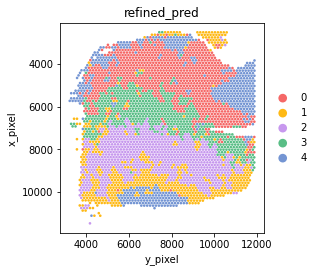

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  21.697848578092884 108.22459712817083 35.67816253929611
Var of x,y,z =  4277492.783403552 5217696.16424447 5217696.16424447
Run 1: l [0.01, 1000], p [0.0, 143.9311855110753]
Run 2: l [0.01, 500.005], p [0.0, 24.00417709350586]
Run 3: l [0.01, 250.0075], p [0.0, 3.421015739440918]
Run 4: l [125.00874999999999, 250.0075], p [0.40880656242370605, 3.421015739440918]
Run 5: l [125.00874999999999, 187.508125], p [0.40880656242370605, 1.4610114097595215]
Run 6: l [125.00874999999999, 156.2584375], p [0.40880656242370605, 0.8357850313186646]
Run 7: l [125.00874999999999, 140.63359375], p [0.40880656242370605, 0.5994189977645874]
recommended l =  132.821171875
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  7
Initializing cluster centers with louvain, resolution =  0.6
Epoch  0
Epoch  10
Res =  0.6 Num of clusters =  5
recommended res 

... storing 'ground_truth' as categorical


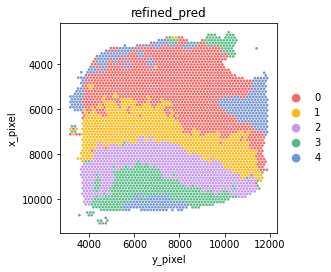

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  19.82204612593531 84.27778465838948 35.60162844038226
Var of x,y,z =  5523141.854672006 5694628.670975485 5694628.670975484
Run 1: l [0.01, 1000], p [0.0, 140.46452764338835]
Run 2: l [0.01, 500.005], p [0.0, 22.12852668762207]
Run 3: l [0.01, 250.0075], p [0.0, 3.0536813735961914]
Run 4: l [125.00874999999999, 250.0075], p [0.36830413341522217, 3.0536813735961914]
Run 5: l [125.00874999999999, 187.508125], p [0.36830413341522217, 1.3020329475402832]
Run 6: l [125.00874999999999, 156.2584375], p [0.36830413341522217, 0.747369647026062]
Run 7: l [125.00874999999999, 140.63359375], p [0.36830413341522217, 0.5377190113067627]
Run 8: l [132.821171875, 140.63359375], p [0.448211669921875, 0.5377190113067627]
recommended l =  136.7273828125
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  6
Initializing cluster centers with louvain, 

... storing 'ground_truth' as categorical


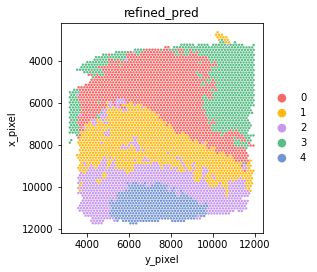

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  18.2343164123278 68.07942655624827 31.390315703932995
Var of x,y,z =  5371684.561352834 5596777.698445029 5596777.698445027
Run 1: l [0.01, 1000], p [0.0, 127.61555050228606]
Run 2: l [0.01, 500.005], p [0.0, 19.975595474243164]
Run 3: l [0.01, 250.0075], p [0.0, 2.7326812744140625]
Run 4: l [125.00874999999999, 250.0075], p [0.3147916793823242, 2.7326812744140625]
Run 5: l [125.00874999999999, 187.508125], p [0.3147916793823242, 1.1461005210876465]
Run 6: l [125.00874999999999, 156.2584375], p [0.3147916793823242, 0.6489328145980835]
Run 7: l [140.63359375, 156.2584375], p [0.4632364511489868, 0.6489328145980835]
Run 8: l [140.63359375, 148.446015625], p [0.4632364511489868, 0.551201343536377]
recommended l =  144.5398046875
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  5
recommended res =  0.7
Initializing cluster centers 

... storing 'ground_truth' as categorical


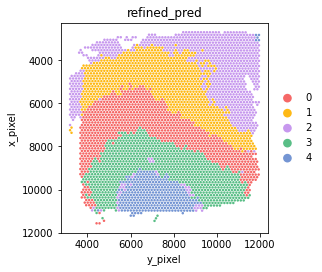

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  33.30687202862215 174.55510595352243 46.84205750749746
Var of x,y,z =  5606737.526317932 4468793.817921193 5606737.526317932
Run 1: l [0.01, 1000], p [0.0, 153.882049263866]
Run 2: l [0.01, 500.005], p [0.0, 28.01544761657715]
Run 3: l [0.01, 250.0075], p [0.0, 4.240330219268799]
Run 4: l [0.01, 125.00874999999999], p [0.0, 0.5157277584075928]
Run 5: l [62.509375, 125.00874999999999], p [0.028496861457824707, 0.5157277584075928]
Run 6: l [93.7590625, 125.00874999999999], p [0.18753135204315186, 0.5157277584075928]
Run 7: l [109.38390625, 125.00874999999999], p [0.32801353931427, 0.5157277584075928]
Run 8: l [117.196328125, 125.00874999999999], p [0.41564691066741943, 0.5157277584075928]
Run 9: l [121.1025390625, 125.00874999999999], p [0.4640926122665405, 0.5157277584075928]
Run 10: l [123.05564453125, 125.00874999999999], p [0.4895068407058716, 0.5157277584075928]
recommended l =  124.032197265625
Start at res =  0.7 

... storing 'ground_truth' as categorical


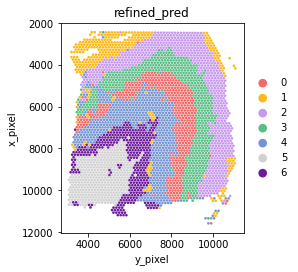

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  40.6795174981594 347.0641903760143 56.49545287887716
Var of x,y,z =  5859121.663035659 4365852.6924909325 5859121.663035658
Run 1: l [0.01, 1000], p [0.0, 167.52424450172117]
Run 2: l [0.01, 500.005], p [0.0, 33.776824951171875]
Run 3: l [0.01, 250.0075], p [0.0, 5.615477561950684]
Run 4: l [0.01, 125.00874999999999], p [0.0, 0.7440891265869141]
Run 5: l [62.509375, 125.00874999999999], p [0.04294753074645996, 0.7440891265869141]
Run 6: l [93.7590625, 125.00874999999999], p [0.2783529758453369, 0.7440891265869141]
Run 7: l [109.38390625, 125.00874999999999], p [0.48020660877227783, 0.7440891265869141]
Run 8: l [109.38390625, 117.196328125], p [0.48020660877227783, 0.6040799617767334]
Run 9: l [109.38390625, 113.29011718749999], p [0.48020660877227783, 0.5401653051376343]
recommended l =  111.33701171874999
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Re

... storing 'ground_truth' as categorical


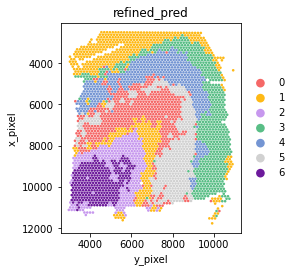

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  49.62069840517693 213.83955761365436 65.7451134889464
Var of x,y,z =  5442102.887514199 4853552.504900458 5442102.887514197
Run 1: l [0.01, 1000], p [0.0, 158.74308932193264]
Run 2: l [0.01, 500.005], p [0.0, 30.9191951751709]
Run 3: l [0.01, 250.0075], p [0.0, 4.8866682052612305]
Run 4: l [0.01, 125.00874999999999], p [0.0, 0.6086124181747437]
Run 5: l [62.509375, 125.00874999999999], p [0.033445119857788086, 0.6086124181747437]
Run 6: l [93.7590625, 125.00874999999999], p [0.22142577171325684, 0.6086124181747437]
Run 7: l [109.38390625, 125.00874999999999], p [0.38756752014160156, 0.6086124181747437]
recommended l =  117.196328125
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  7
recommended res =  0.7
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Epoch  20
Epoch  30
Epoch  40
Epoch  50
Epoc

... storing 'ground_truth' as categorical


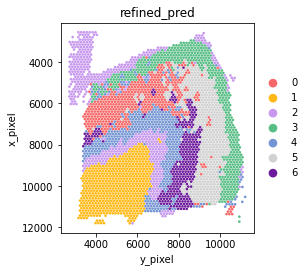

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Calculateing adj matrix using histology image...
Var of c0,c1,c2 =  31.38774432978399 176.46260451263274 62.446555053691554
Var of x,y,z =  5151574.126358716 4424956.777224097 5151574.126358716
Run 1: l [0.01, 1000], p [0.0, 160.74227964648844]
Run 2: l [0.01, 500.005], p [0.0, 30.76064682006836]
Run 3: l [0.01, 250.0075], p [0.0, 4.8107829093933105]
Run 4: l [0.01, 125.00874999999999], p [0.0, 0.608553409576416]
Run 5: l [62.509375, 125.00874999999999], p [0.034670352935791016, 0.608553409576416]
Run 6: l [93.7590625, 125.00874999999999], p [0.22527754306793213, 0.608553409576416]
Run 7: l [109.38390625, 125.00874999999999], p [0.3904612064361572, 0.608553409576416]
recommended l =  117.196328125
Start at res =  0.7 step =  0.1
Initializing cluster centers with louvain, resolution =  0.7
Epoch  0
Epoch  10
Res =  0.7 Num of clusters =  8
Initializing cluster centers with louvain, resolution =  0.6
Epoch  0
Epoch  10
Res =  0.6 Num of clusters =  6
Step changed to 0.05
Initializing clu

... storing 'ground_truth' as categorical


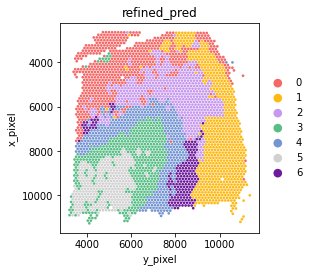

In [9]:
df = pd.DataFrame(columns=['Sample', 'Score', 'PCA_or_UMAP', 'Method', "test"])
for i in range(12):
    sample = sample_list[i]
    GROUND_TRUTH_PATH = BASE_PATH / sample / "cluster_labels_{}.csv".format(sample)
    ground_truth_df = pd.read_csv(GROUND_TRUTH_PATH, sep=',', index_col=0)
    ground_truth_df.index = ground_truth_df.index.map(lambda x: x[7:])

    le = LabelEncoder()
    ground_truth_le = le.fit_transform(list(ground_truth_df["ground_truth"].values))
    ground_truth_df["ground_truth_le"] = ground_truth_le
    
    adata=sc.read(BASE_PATH / sample / "{}_spaGCN.h5ad".format(sample))
    
    ground_truth_df = ground_truth_df.reindex(adata.obs_names)
    n_cluster = len((set(ground_truth_df["ground_truth"]))) - 1
    adata.obs['ground_truth'] = ground_truth_df["ground_truth"]
    ground_truth_le = ground_truth_df["ground_truth_le"]
    
    img=cv2.imread(str(BASE_PATH / sample /"{}_full_image.tif".format(sample)))
    
    adata.obs["x_array"]=adata.obs["x2"]
    adata.obs["y_array"]=adata.obs["x3"]
    adata.obs["x_pixel"]=adata.obs["x4"]
    adata.obs["y_pixel"]=adata.obs["x5"]
    x_array=adata.obs["x_array"].tolist()
    y_array=adata.obs["y_array"].tolist()
    x_pixel=adata.obs["x_pixel"].tolist()
    y_pixel=adata.obs["y_pixel"].tolist()
    
    s=1
    b=49
    adj=spg.calculate_adj_matrix(x=x_pixel,y=y_pixel, x_pixel=x_pixel, y_pixel=y_pixel, image=img, beta=b, alpha=s, histology=True)
    
    adata.var_names_make_unique()
    spg.prefilter_genes(adata,min_cells=3) # avoiding all genes are zeros
    spg.prefilter_specialgenes(adata)
    #Normalize and take log for UMI
    sc.pp.normalize_per_cell(adata)
    sc.pp.log1p(adata)

    p=0.5 
    #Find the l value given p
    l=spg.search_l(p, adj, start=0.01, end=1000, tol=0.01, max_run=100)
    
    #For this toy data, we set the number of clusters=7 since this tissue has 7 layers
    n_clusters=n_cluster
    #Set seed
    r_seed=t_seed=n_seed=100
    #Search for suitable resolution
    res=spg.search_res(adata, adj, l, n_clusters, start=0.7, step=0.1, tol=5e-3, lr=0.05, 
                   max_epochs=20, r_seed=r_seed, t_seed=t_seed, n_seed=n_seed)
    
    clf=spg.SpaGCN()
    clf.set_l(l)
    #Set seed
    random.seed(r_seed)
    torch.manual_seed(t_seed)
    np.random.seed(n_seed)
    #Run
    clf.train(adata,adj,init_spa=True,init="louvain",res=res, tol=5e-3, lr=0.05, max_epochs=200)
    y_pred, prob=clf.predict()
    adata.obs["pred"]= y_pred
    adata.obs["pred"]=adata.obs["pred"].astype('category')
    #Do cluster refinement(optional)
    #shape="hexagon" for Visium data, "square" for ST data.
    adj_2d=spg.calculate_adj_matrix(x=x_array,y=y_array, histology=False)
    refined_pred=spg.refine(sample_id=adata.obs.index.tolist(), pred=adata.obs["pred"].tolist(), dis=adj_2d, shape="hexagon")
    adata.obs["refined_pred"]=refined_pred
    adata.obs["refined_pred"]=adata.obs["refined_pred"].astype('category')
    
    plot_color=["#F56867","#FEB915","#C798EE","#59BE86","#7495D3","#D1D1D1","#6D1A9C","#15821E","#3A84E6","#997273","#787878","#DB4C6C","#9E7A7A","#554236","#AF5F3C","#93796C","#F9BD3F","#DAB370","#877F6C","#268785"]
    
    #Plot refined spatial domains
    domains="refined_pred"
    num_celltype=len(adata.obs[domains].unique())
    adata.uns[domains+"_colors"]=list(plot_color[:num_celltype])
    ax=sc.pl.scatter(adata,alpha=1,x="y_pixel",y="x_pixel",color=domains,title=domains,color_map=plot_color,show=False,size=100000/adata.shape[0])
    ax.set_aspect('equal', 'box')
    ax.axes.invert_yaxis()
    # plt.savefig("./mouse_brain_10x/refined_pred.png", dpi=600)
    # plt.close()
    plt.show()
    
    methods_ = "spaGCN"
    results_df = calculate_clustering_matrix(adata.obs["refined_pred"], ground_truth_le, sample, methods_)
    df = df.append(results_df, ignore_index=True)

In [12]:
# read clustering results from other methods
pca_df = pd.read_csv("/home/uqxtan9/90days/Q1851/Xiao/Working_project/stlearn_revision_v/stSME_matrices_other_methods.csv",index_col=0)

In [13]:
pca_df

,Unnamed: 0.1,Sample,Score,PCA_or_UMAP,Method,Method_Group,test
0,0.0,151507,0.257911,pca,SpaDE,pca_SpatialDE,Adjusted_Rand_Score
1,1.0,151507,0.235600,pca,SpaDE.pool,pca_SpatialDE_pool,Adjusted_Rand_Score
2,2.0,151507,0.269475,pca,HVG,pca_HVG,Adjusted_Rand_Score
3,3.0,151507,0.224838,pca,pseudobulk,pca_pseudobulk,Adjusted_Rand_Score
4,4.0,151507,0.049971,pca,markers,pca_markers,Adjusted_Rand_Score
...,...,...,...,...,...,...,...
1002,NaN,151676,0.305158,pca,spata,NaN,Adjusted_Rand_Score
1003,NaN,151676,0.401321,pca,spata,NaN,Normalized_Mutual_Info_Score
1005,NaN,151676,0.401100,pca,spata,NaN,Homogeneity_Score
1006,NaN,151676,0.401543,pca,spata,NaN,Completeness_Score


In [14]:
df_all = pca_df.append(df, ignore_index=True)

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("white")
from matplotlib.patches import PathPatch

def adjust_box_widths(g, fac):
    """
    Adjust the widths of a seaborn-generated boxplot.
    """

    # iterating through Axes instances
    for ax in g.axes:

        # iterating through axes artists:
        for c in ax.get_children():

            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                xmin = np.min(verts_sub[:, 0])
                xmax = np.max(verts_sub[:, 0])
                xmid = 0.5*(xmin+xmax)
                xhalf = 0.5*(xmax - xmin)

                # setting new width of box
                xmin_new = xmid-fac*xhalf
                xmax_new = xmid+fac*xhalf
                verts_sub[verts_sub[:, 0] == xmin, 0] = xmin_new
                verts_sub[verts_sub[:, 0] == xmax, 0] = xmax_new

                # setting new width of median line
                for l in ax.lines:
                    if np.all(l.get_xdata() == [xmin, xmax]):
                        l.set_xdata([xmin_new, xmax_new])


class GridShader():
    def __init__(self, ax, first=True, **kwargs):
        self.spans = []
        self.sf = first
        self.ax = ax
        self.kw = kwargs
        self.ax.autoscale(False, axis="x")
        self.cid = self.ax.callbacks.connect('xlim_changed', self.shade)
        self.shade()
    def clear(self):
        for span in self.spans:
            try:
                span.remove()
            except:
                pass
    def shade(self, evt=None):
        self.clear()
        xticks = self.ax.get_xticks()
        xlim = self.ax.get_xlim()
        xticks = xticks[(xticks > xlim[0]) & (xticks < xlim[-1])]
        locs = np.concatenate(([[xlim[0]], xticks+0.5, [xlim[-1]]]))
        
        start = locs[1-int(self.sf)::2]  
        end = locs[2-int(self.sf)::2]

        for s, e in zip(start, end):
            self.spans.append(self.ax.axvspan(s, e, zorder=0, **self.kw))




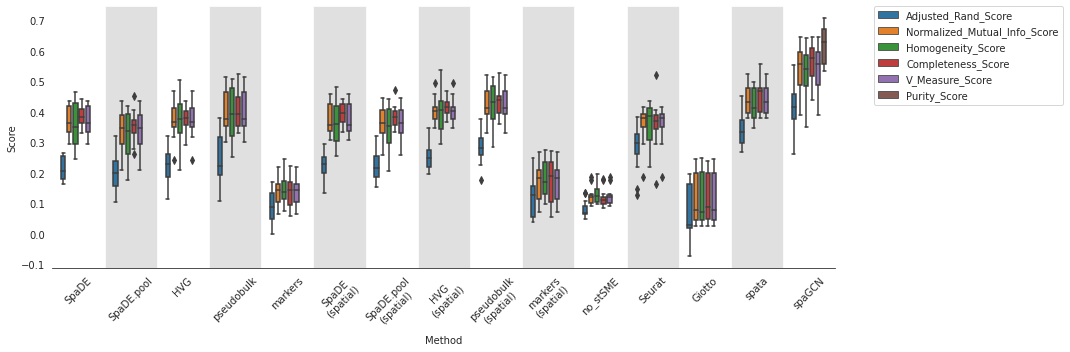

In [16]:
import seaborn as sns
fig = plt.figure(figsize=(15, 5))
a = sns.boxplot(x="Method", y="Score", hue="test",

               width=0.7,
               data=df_all)
a.set_xticklabels(a.get_xticklabels(), rotation=45)
sns.despine(left=True)
a.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
adjust_box_widths(fig, 0.7)
plt.autoscale()
gs = GridShader(a, facecolor="lightgrey", first=False, alpha=0.7)
plt.tight_layout()
#plt.savefig("./clustering_performace.png", dpi=300)
plt.show()

In [17]:
df_all.to_csv("/home/uqxtan9/90days/Q1851/Xiao/Working_project/stlearn_revision_v/stSME_matrices_other_methods_spaGCN.csv")


